# Exploratory analysis of mempool telementry experiment

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(ltsa, quietly=TRUE)
})

In [2]:
bauTime <- as.POSIXct("2025-11-22 02:00:00", tz = "UTC")

In [3]:
bauSlot <- 172210527

## Mempool vs blocks

In [4]:
mempoolBlocks <- fread("mempool-vs-blocks.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolBlocks) <- c("Region", "Slot", "Block hash", "Tx hash", "Tx hash8", "Slot time", "Block logged", "Tx logged", "Mempool - slot time [s]", "Block - slot time [s]", "Tx seen first")
mempoolBlocks[`Region` == '', `Region`:=NA]
mempoolBlocks %>% summary

            Region            Slot          
               :     0   Min.   :172020832  
 ap-northeast-1:141172   1st Qu.:172237207  
 eu-central-1  :191057   Median :172371668  
 us-east-2     :140292   Mean   :172358227  
 NA's          :  2423   3rd Qu.:172484179  
                         Max.   :172602993  
                                            
                                                            Block hash    
 4b9b817fb2ebd0959b7d31decc8225f6c4de874c2359706c327753c3961f4cc9:   237  
 b7dd177e8bf0ad0a52d41b1747bfde10b329ff4167bb408a5d7fef2735248e03:   234  
 90ab0197e16e39cf5af31bd1d193151f3582a2bee468ea953987e4b1c59de280:   224  
 b04ba46586aef364000ee0e42fa5fba6cdfae2294950e1ffb6c7fa2059fb7460:   222  
 9df8b4b6540b29d644074144490c0abb76d49ca62e11f9d4822ed1e0b6f8c0b2:   216  
 007e315be01f4cfb74e3c1c95f664aca16bf461be4cae4fe6e78e783896ea0b1:   201  
 (Other)                                                         :473610  
                                        

## Probability that a transaction is in one node's mempool, given that it is in another node's mempool.

In [5]:
arrivals <- dcast(
    mempoolBlocks[!is.na(`Tx logged`)],
    `Slot` + `Tx hash` ~ `Region`,
    value.var = "Tx logged",
    fun.aggregate = function(x) {
        x[1]
    }
)
arrivals %>% summary

      Slot          
 Min.   :172024805  
 1st Qu.:172197809  
 Median :172352157  
 Mean   :172337772  
 3rd Qu.:172467828  
 Max.   :172602993  
                    
                                                             Tx hash      
 000076f241bac990ec1f45cda72f343f80bfe8d73fce67cc4328269d0fe13ae3:     1  
 000109649f9a8f10c9a4bd88bee05aa2b192b88c6f55c854157dc0a8860cafec:     1  
 00017d9d70055b1fa0a1827644fdc4b94bfb43c0606f62c017af4fe05d3f1664:     1  
 0001b087d39d2da5e69699d81bac4a6e580df07af5389952aefcfde632b9dc0e:     1  
 0001b9d5294bae38b731b1bcc1cdcf7c5119d31736b88d5bd9529668a0153eb8:     1  
 000216c68da0895ac434fec8b303eb0dd7e287806b73860f90d59ed48da6c89d:     1  
 (Other)                                                         :173256  
 ap-northeast-1                    eu-central-1                   
 Min.   :2025-11-21 18:13:20.31   Min.   :2025-11-19 22:24:02.38  
 1st Qu.:2025-11-23 04:35:58.04   1st Qu.:2025-11-21 20:12:11.10  
 Median :2025-11-24 12:29:01.55

In [6]:
pxy <- function(x, y) {
    if (is.na(y))
        NA
    else if (is.na(x))
        0
    else
        1
}

In [7]:
combinations <-
    arrivals[, .(
        `Slot`,
        `Tx hash`,
        `P(eu|ap)`=mapply(pxy, `eu-central-1`, `ap-northeast-1`),
        `P(us|ap)`=mapply(pxy, `us-east-2`, `ap-northeast-1`),
        `P(ap|eu)`=mapply(pxy, `ap-northeast-1`, `eu-central-1`),
        `P(us|eu)`=mapply(pxy, `us-east-2`, `eu-central-1`),
        `P(ap|us)`=mapply(pxy, `ap-northeast-1`, `us-east-2`),
        `P(eu|us)`=mapply(pxy, `eu-central-1`, `us-east-2`)
    )]
combinations %>% summary

      Slot          
 Min.   :172024805  
 1st Qu.:172197809  
 Median :172352157  
 Mean   :172337772  
 3rd Qu.:172467828  
 Max.   :172602993  
                    
                                                             Tx hash      
 000076f241bac990ec1f45cda72f343f80bfe8d73fce67cc4328269d0fe13ae3:     1  
 000109649f9a8f10c9a4bd88bee05aa2b192b88c6f55c854157dc0a8860cafec:     1  
 00017d9d70055b1fa0a1827644fdc4b94bfb43c0606f62c017af4fe05d3f1664:     1  
 0001b087d39d2da5e69699d81bac4a6e580df07af5389952aefcfde632b9dc0e:     1  
 0001b9d5294bae38b731b1bcc1cdcf7c5119d31736b88d5bd9529668a0153eb8:     1  
 000216c68da0895ac434fec8b303eb0dd7e287806b73860f90d59ed48da6c89d:     1  
 (Other)                                                         :173256  
    P(eu|ap)        P(us|ap)        P(ap|eu)        P(us|eu)    
 Min.   :0.00    Min.   :0.00    Min.   :0.000   Min.   :0.000  
 1st Qu.:1.00    1st Qu.:1.00    1st Qu.:0.000   1st Qu.:0.000  
 Median :1.00    Median :1.00    Medi

In [8]:
probabilities <- combinations[
    ,
    .(
        `P(eu|ap)`=mean(`P(eu|ap)`, na.rm=TRUE),
        `P(us|ap)`=mean(`P(us|ap)`, na.rm=TRUE),
        `P(ap|eu)`=mean(`P(ap|eu)`, na.rm=TRUE),
        `P(us|eu)`=mean(`P(us|eu)`, na.rm=TRUE),
        `P(ap|us)`=mean(`P(ap|us)`, na.rm=TRUE),
        `P(eu|us)`=mean(`P(eu|us)`, na.rm=TRUE)
    ),
    .(
        `BAU?`=`Slot`>=bauSlot
    )
]
probabilities

BAU?,P(eu|ap),P(us|ap),P(ap|eu),P(us|eu),P(ap|us),P(eu|us)
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,0.9822689,0.2015837,0.1195024,0.02676552,0.8547445,0.9328467
TRUE,0.9372497,0.9154157,0.9791523,0.91508573,0.9695700,0.9277430


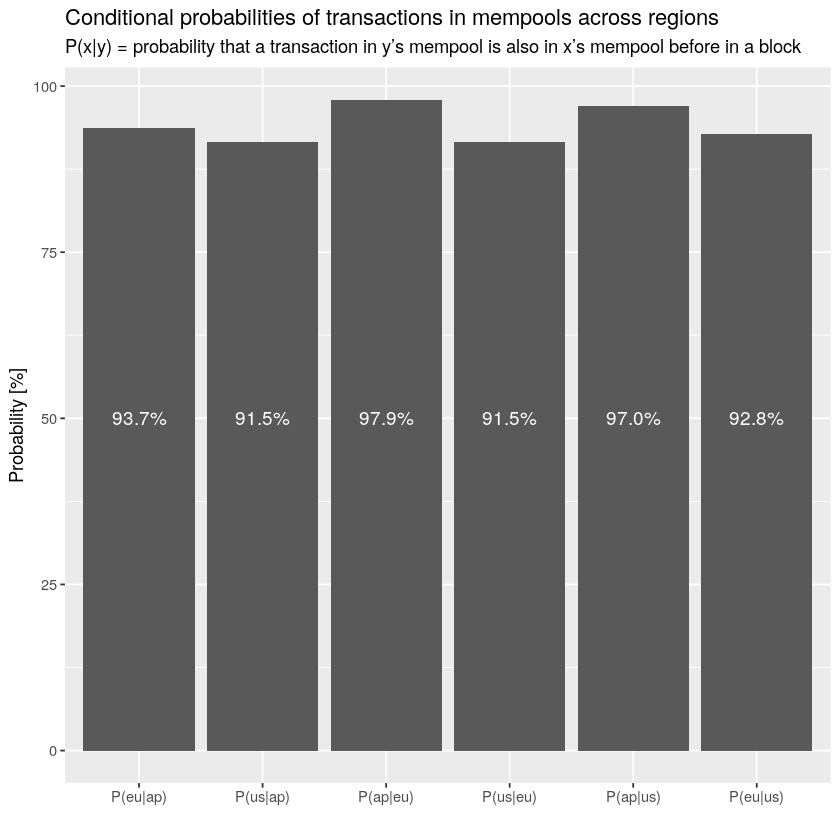

In [9]:
ggplot(
    melt(probabilities, id.vars="BAU?", variable.name="Condition", value.name="Probability")[`BAU?` == TRUE, .(`Condition`, `Probability [%]`=100*`Probability`)],
    aes(x=`Condition`, y=`Probability [%]`)
) +
    geom_bar(stat="identity") +
    geom_text(
        aes(label=sprintf("%.1f%%", `Probability [%]`)),
        y=50,
        size=4,
        color="white"
      ) +
    xlab("") +
    ggtitle(
        "Conditional probabilities of transactions in mempools across regions",
        "P(x|y) = probability that a transaction in y’s mempool is also in x’s mempool before in a block"
    )

In [10]:
ggsave("conditional-probability-regions.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("conditional-probability-regions.svg", units="in", dpi=150, width=8, height=6)

## Probability that a transaction is in the node's mempool, given that it is later received in a block.

In [12]:
pmb <- mempoolBlocks[
    !is.na(`Region`),
    .(
        `P(mempool|block)`=mean(mapply(function(x) if (is.na(x)) 0 else 1, `Tx logged`))
    ),
    .(
        `Region`,
        `BAU?`=`Slot`>=bauSlot
    )
]
pmb

Region,BAU?,P(mempool|block)
<fct>,<lgl>,<dbl>
ap-northeast-1,FALSE,0.37168991
ap-northeast-1,TRUE,0.96712549
eu-central-1,FALSE,0.73007728
eu-central-1,TRUE,0.92654823
us-east-2,FALSE,0.09284988
us-east-2,TRUE,0.91295793


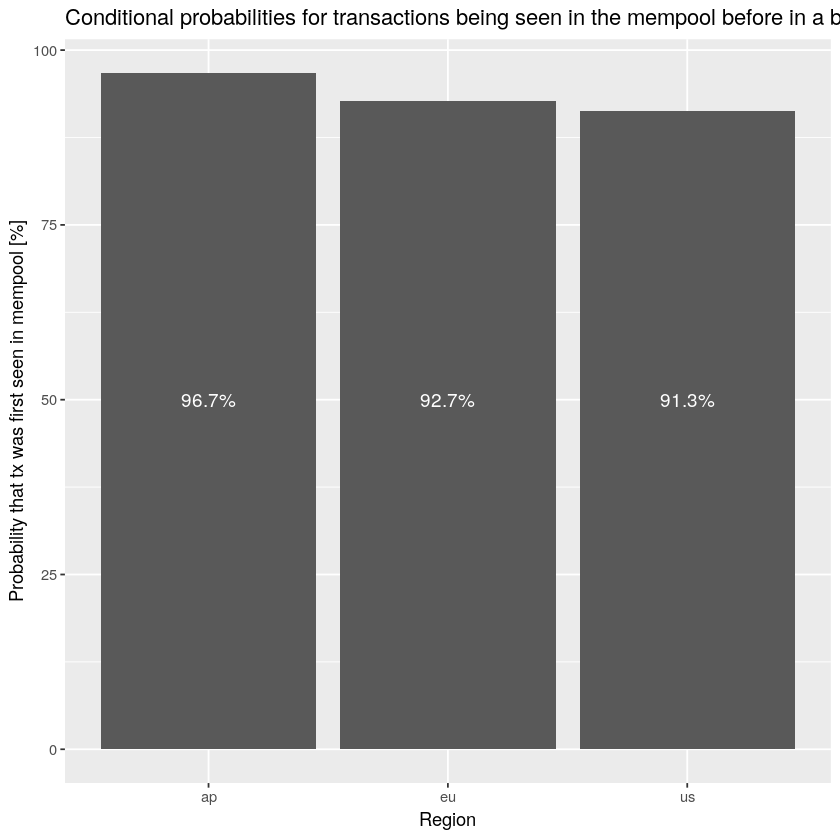

In [13]:
ggplot(
    pmb[`BAU?` == TRUE, .(`Region`=substr(`Region`,1,2), `Probability that tx was first seen in mempool [%]`=100*`P(mempool|block)`)],
    aes(x=`Region`, y=`Probability that tx was first seen in mempool [%]`)
) +
    geom_bar(stat="identity") +
    geom_text(
        aes(label=sprintf("%.1f%%", `Probability that tx was first seen in mempool [%]`)),
        y=50,
        size=4,
        color="white"
    ) +
    ggtitle(
        "Conditional probabilities for transactions being seen in the mempool before in a block"
    )

In [14]:
ggsave("conditional-probability-mempool-block.png", units="in", dpi=150, width=8, height=6)

In [15]:
ggsave("conditional-probability-mempool-block.svg", units="in", dpi=150, width=8, height=6)

## Distribution of a transaction's arrival time prior to the slot where the block was produced.

We see that the distribution of arrival times is consistent with uniformly distribution injection of transactions into the memory pool, rapid diffusion of them, and the block waiting time associated with the Praos active-slot coefficient.

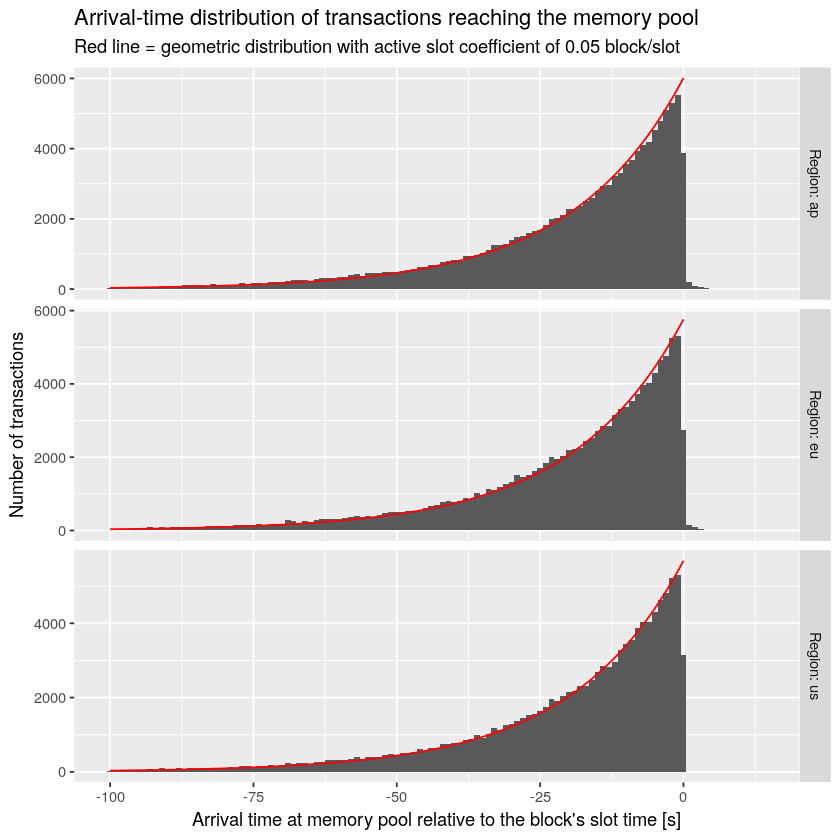

In [16]:
ggplot(
    mempoolBlocks[
        !is.na(`Region`) & `Slot` >= bauSlot  & `Tx seen first` == TRUE & `Mempool - slot time [s]` > -100, 
        .(`Region`=paste("Region:",substr(`Region`,1,2)), `Mempool - slot time [s]`)
    ], 
    aes(x=`Mempool - slot time [s]`)
) +
    geom_histogram(binwidth=1) +
    geom_line(
        data=CJ(`lag`=0:100, `Region`=paste("Region:",substr(mempoolBlocks[,unique(`Region`)],1,2)))[
            mempoolBlocks[
                !is.na(`Region`) & `Slot` >= bauSlot  & `Tx seen first` == TRUE & `Mempool - slot time [s]` > -100, 
                .N, 
                .(`Region`=paste("Region:",substr(`Region`,1,2)))
            ],
            on="Region"
        ][, .(`Region`, `lag`, `Count`=`N` * dgeom(`lag`, 0.05))],
        aes(x=-`lag`, y=`Count`),
        color="red"
    ) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Arrival time at memory pool relative to the block's slot time [s]") +
    ylab("Number of transactions") +
    ggtitle(
        "Arrival-time distribution of transactions reaching the memory pool",
        "Red line = geometric distribution with active slot coefficient of 0.05 block/slot"
    )

In [17]:
ggsave("transaction-arrival.png", units="in", dpi=150, width=8, height=6)

In [18]:
ggsave("transaction-arrival.svg", units="in", dpi=150, width=8, height=6)

## Fraction of block's transactions received in the node's mempool before in their block.

In [19]:
pmbr <- mempoolBlocks[
    !is.na(`Region`),
    .(
        `P(mempool|block)`=mean(mapply(function(x) if (is.na(x)) 0 else 1, `Tx logged`))
    ),
    .(
        `BAU?`=`Slot`>=bauSlot,
        `Region`=paste("Region:",substr(`Region`,1,2)),
        `Slot`
    )
]
pmbr[, .(`P(mempool|block)`=mean(`P(mempool|block)`)), .(`BAU?`, `Region`)]

BAU?,Region,P(mempool|block)
<lgl>,<chr>,<dbl>
FALSE,Region: ap,0.4730102
TRUE,Region: ap,0.9607021
FALSE,Region: eu,0.6441413
TRUE,Region: eu,0.9190227
FALSE,Region: us,0.1231581
TRUE,Region: us,0.9242111


In [20]:
pmbr[`BAU?` == TRUE, .(`Fraction = 0%`=mean(`P(mempool|block)`==0), `Fraction = 100%`=mean(`P(mempool|block)`==1)), .(`Region`)]

Region,Fraction = 0%,Fraction = 100%
<chr>,<dbl>,<dbl>
Region: ap,0.01680922,0.8944524
Region: eu,0.05200524,0.8665953
Region: us,0.07132685,0.8960361


A reasonable approximation for the fraction of a block's transactions being previously seen in the memory pool is a distribution with masses at 0% and 100% and a uniform distriubtion between those.

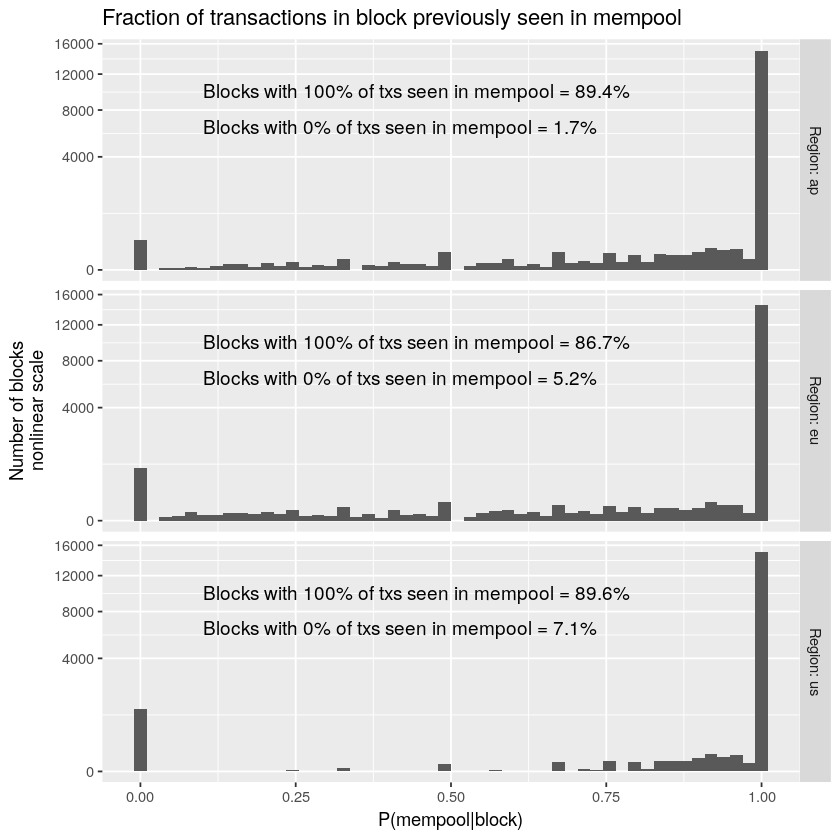

In [21]:
ggplot(pmbr[`BAU?` == TRUE], aes(x=`P(mempool|block)`)) +
    geom_histogram(bins=50) +
    geom_text(
        data=pmbr[`BAU?` == TRUE, .(`Fraction = 0%`=mean(`P(mempool|block)`==0), `Fraction = 100%`=mean(`P(mempool|block)`==1)), .(`Region`)],
        aes(label=sprintf("Blocks with 0%% of txs seen in mempool = %.1f%%", 100 * `Fraction = 0%`)),
        x=0.1, y=80,
        hjust=0,
        size=4
    ) +
    geom_text(
        data=pmbr[`BAU?` == TRUE, .(`Fraction = 0%`=mean(`P(mempool|block)`==0), `Fraction = 100%`=mean(`P(mempool|block)`==1)), .(`Region`)],
        aes(label=sprintf("Blocks with 100%% of txs seen in mempool = %.1f%%", 100 * `Fraction = 100%`)),
        x=0.1, y=100,
        hjust=0,
        size=4
    ) +
    scale_y_sqrt() +
    facet_grid(`Region` ~ .) +
    ylab("Number of blocks\nnonlinear scale") +
    ggtitle("Fraction of transactions in block previously seen in mempool")

In [22]:
ggsave("block-fraction.png", units="in", dpi=150, width=8, height=6)

In [23]:
ggsave("block-fraction.svg", units="in", dpi=150, width=8, height=6)

## Temporal autocorrelation of fraction of block's transactions received in the node's mempool before in their block.

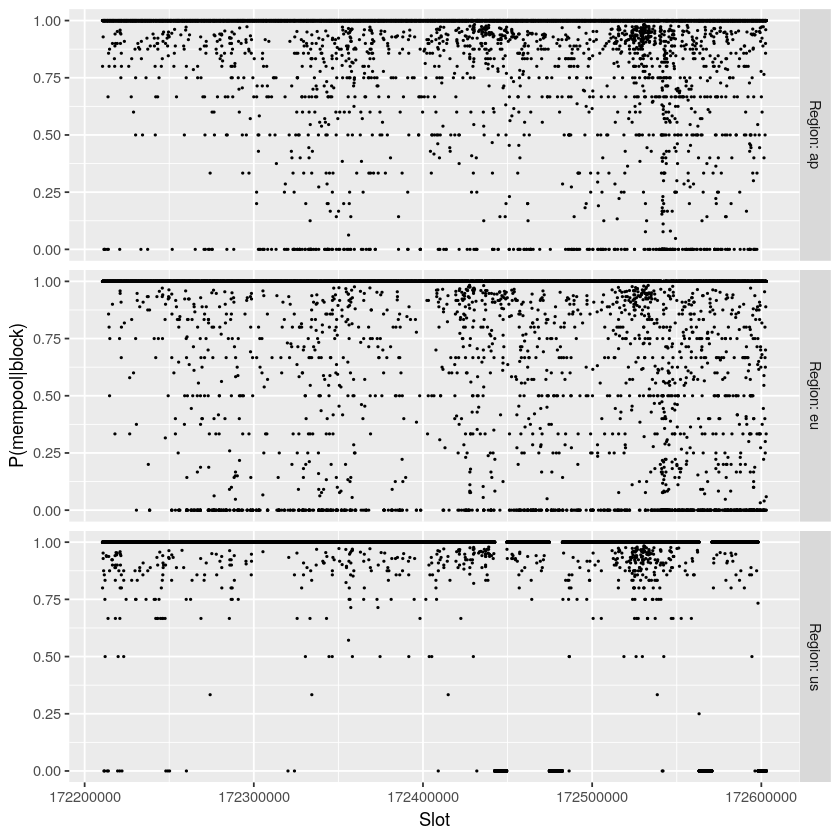

In [24]:
ggplot(pmbr[`BAU?` == TRUE], aes(x=`Slot`, y=`P(mempool|block)`)) +
    geom_point(size=0.25) +
    facet_grid(`Region` ~ .)

In [25]:
bacf <-
    rbind(
        cbind(
            `Region`="Region: ap",
            with(
                acf(pmbr[`BAU?` == TRUE & `Region`=="Region: ap", `P(mempool|block)`, .(`Slot`)][order(`Slot`)][, `P(mempool|block)`], lag.max=250, plot=FALSE),
                data.frame(lag, acf)
            )
        ),
        cbind(
            `Region`="Region: eu",
            with(
                acf(pmbr[`BAU?` == TRUE & `Region`=="Region: eu", `P(mempool|block)`, .(`Slot`)][order(`Slot`)][, `P(mempool|block)`], lag.max=250, plot=FALSE),
                data.frame(lag, acf)
            )
        ),
        cbind(
            `Region`="Region: us",
            with(
                acf(pmbr[`BAU?` == TRUE & `Region`=="Region: us", `P(mempool|block)`, .(`Slot`)][order(`Slot`)][, `P(mempool|block)`], lag.max=250, plot=FALSE),
                data.frame(lag, acf)
            )
        )
    )
colnames(bacf) <- c("Region", "Lag [blocks]", "Autocorrelation")
bacf %>% summary

    Region           Lag [blocks] Autocorrelation   
 Length:753         Min.   :  0   Min.   :0.006804  
 Class :character   1st Qu.: 62   1st Qu.:0.043884  
 Mode  :character   Median :125   Median :0.069114  
                    Mean   :125   Mean   :0.218570  
                    3rd Qu.:188   3rd Qu.:0.330734  
                    Max.   :250   Max.   :1.000000  

It is interesting the in the `ap` and `eu` region, the correlation for a block's transactions being previously seen in the mempool persists for less than five blocks but for the `us` region it persisted for hundreds of blocks.

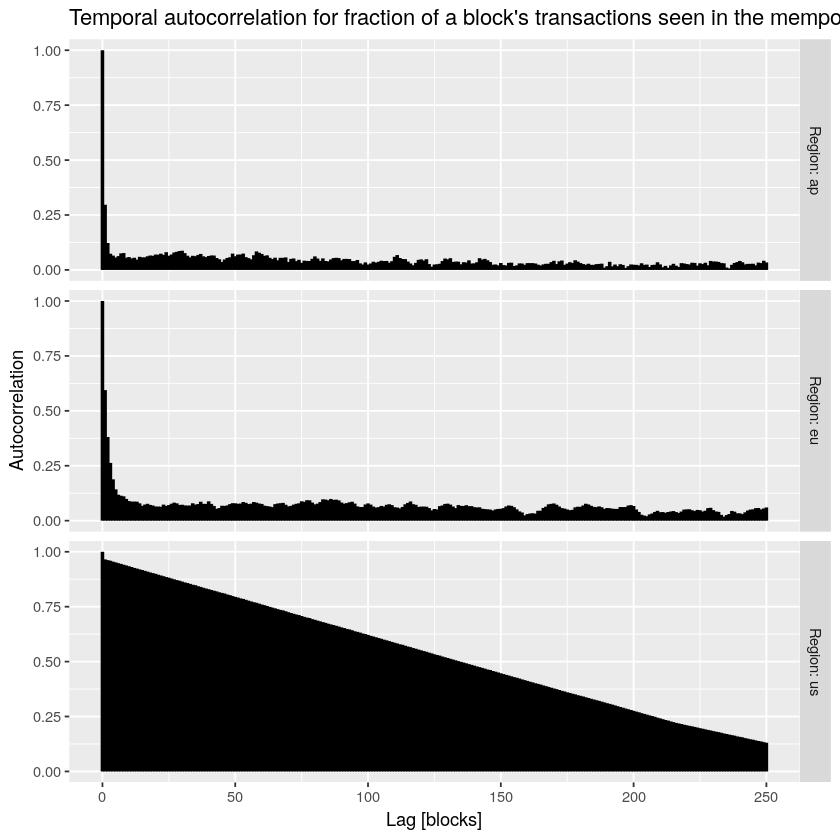

In [26]:
ggplot(bacf, aes(x=`Lag [blocks]`, y=`Autocorrelation`)) +
    geom_segment(aes(xend=`Lag [blocks]`, yend = 0), linewidth = 1) +
    facet_grid(`Region` ~ .) +
    ggtitle("Temporal autocorrelation for fraction of a block's transactions seen in the mempool")

In [27]:
ggsave("block-autocorrelation.png", units="in", dpi=150, width=8, height=6)

In [28]:
ggsave("block-autocorrelation.svg", units="in", dpi=150, width=8, height=6)

## Spatial autocorrelation of fraction of mempool transactions received in the node's mempool before in their block.

In [29]:
bcor <- cor(dcast(pmbr[`BAU?` == TRUE], `Slot` ~ `Region`, value.var ="P(mempool|block)")[, -1], use="pairwise.complete.obs")
bcor

,Region: ap,Region: eu,Region: us
Region: ap,1.0000000,0.24615244,0.01247320
Region: eu,0.2461524,1.00000000,0.02953728
Region: us,0.0124732,0.02953728,1.00000000


At the block level there isn't much correlation between fractio of transactions seen in the mempool before in the block in different regions.

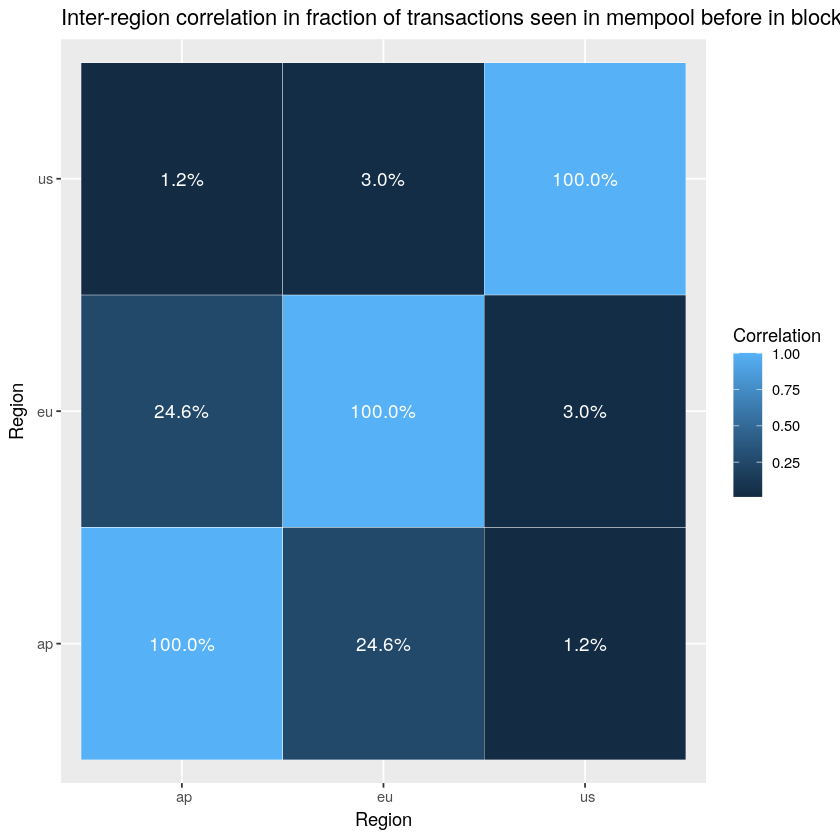

In [30]:
ggplot(
    melt(cbind(`Region 1`=row.names(bcor), as.data.table(bcor)), id.vars="Region 1", variable.name="Region 2", value.name="Correlation")[, .(
        `Region 1`=substr(`Region 1`,8,10), `Region 2`=substr(`Region 2`,8,10), `Correlation`
    )],
    aes(x=`Region 1`, y=`Region 2`, fill=`Correlation`)
) +
    geom_tile(color="white") +
    geom_text(aes(label=sprintf("%.1f%%",100*`Correlation`)), size = 4, color = "white") +
    xlab("Region") +
    ylab("Region") +
    ggtitle("Inter-region correlation in fraction of transactions seen in mempool before in block")

In [31]:
ggsave("block-spatiocorrelation.png", units="in", dpi=150, width=8, height=6)

In [32]:
ggsave("block-spatiocorrelation.svg", units="in", dpi=150, width=8, height=6)

## Probability that a transaction is in a block received by a node, given that is was previously received in the node's memory pool.

Actually, there were no observations where a transaction reached a memory pool but didn't reach a block.

In [33]:
mempoolBlocks[is.na(`Block logged`) & !is.na(`Tx logged`), .N]

[1] 0

## Distribution of number of nodes that see that transactions before it appears in a block.

In [34]:
mempoolBlocks[
    `Slot` >= bauSlot, .N, .(`Region`, `Tx hash`)
][
    , .(`Number of regions`=.N), .(`Tx hash`)
][
    , .(`Number of transactions`=.N), .(`Number of regions`)
][
    order(`Number of regions`)
]

Number of regions,Number of transactions
<int>,<int>
1,69
2,196
3,125318


## Tracking of CF's "canary" transactions' arrival in memory pools.

In [35]:
canary <- fread("canary.tsv.gz", stringsAsFactors=TRUE)
colnames(canary) <- c("Canary address", "Tx hash", "Slot submitted", "Canary delay")
canary %>% summary

                                                    Canary address
 addr1vx2uvrm53dak4x3u0txy98r2jpg2nhy0n82vk8a6v9wmk4s8up888:163   
 addr1vx7gvyvy2r7mycya22f3x88wlgra2552uxm8xz2g0v3g6yccgyydv:163   
 addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d:163   
 addr1vy0zwnn5yj4h3s25xuere4h38np4z6gcng2mdgxg0mapxagl6x66d:162   
                                                                  
                                                                  
                                                                  
                                                             Tx hash   
 4efa94f4aa8b8aa5d59431752cf0c4d7306b4c321105c7ebfc015819b045c4fa:  2  
 53597b93ac2de670f6eeeeaaa658fd20c111ed8323cf26631c1fc44230ae2d45:  2  
 bbefe6d53028de74785758ee18a5b8fc0b2863c917a41bfe2785fd0fe73929ed:  2  
 f61a35f8f5ee8c0aac3bc84b7889a59b6c7bdde7ebdcb5c330353710da3cc1fb:  2  
 0003d419d3ed79b6d6711004e951e3e818d03a1df633b3e02070a6c84821f735:  1  
 00539f487af5aa4b01e48776987d1a7

In [36]:
canary[
    mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
    on="Tx hash", 
    nomatch=0
][!is.na(`Tx logged`), .N, .(`Canary address`, `Tx hash`, `Region`)][
    ,
    .(`Number of regions`=.N),
    .(`Canary address`, `Tx hash`)
][
    ,
    .(`Count`=.N),
    .(`Canary address`, `Number of regions`)
]

Canary address,Number of regions,Count
<fct>,<int>,<int>
addr1vy0zwnn5yj4h3s25xuere4h38np4z6gcng2mdgxg0mapxagl6x66d,3,92
addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d,3,91
addr1vx7gvyvy2r7mycya22f3x88wlgra2552uxm8xz2g0v3g6yccgyydv,3,92
addr1vx2uvrm53dak4x3u0txy98r2jpg2nhy0n82vk8a6v9wmk4s8up888,3,95
addr1vy0zwnn5yj4h3s25xuere4h38np4z6gcng2mdgxg0mapxagl6x66d,2,17
addr1vx2uvrm53dak4x3u0txy98r2jpg2nhy0n82vk8a6v9wmk4s8up888,2,14
addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d,2,17
addr1vx7gvyvy2r7mycya22f3x88wlgra2552uxm8xz2g0v3g6yccgyydv,2,16
addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d,1,1


In [37]:
canary[`Slot submitted` >= bauSlot, .N, .(`Canary address`)]

Canary address,N
<fct>,<int>
addr1vy0zwnn5yj4h3s25xuere4h38np4z6gcng2mdgxg0mapxagl6x66d,109
addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d,109
addr1vx7gvyvy2r7mycya22f3x88wlgra2552uxm8xz2g0v3g6yccgyydv,109
addr1vx2uvrm53dak4x3u0txy98r2jpg2nhy0n82vk8a6v9wmk4s8up888,109


Thus the majority of the transactions reached all three nodes.

## Tracking of natural and induced congestion on arrival in memory pools.

Each of these transactions was [8717 bytes](https://adastat.net/transactions/d798ed9489cdd977fa2155894edc27d3cb0137fcdb9454133448a242383e1384), so 20 of them completely fill a memory pool on a node configured with defaults.

In [38]:
20 * 8717

[1] 174340

In [39]:
congestions <- fread("congestions.tsv.gz", stringsAsFactors=TRUE)
colnames(congestions) <- c("Submission time", "Tx hash")
congestions %>% summary

 Submission time                 
 Min.   :2025-11-26 14:01:16.00  
 1st Qu.:2025-11-26 14:01:16.00  
 Median :2025-11-26 14:23:16.00  
 Mean   :2025-11-26 14:12:32.92  
 3rd Qu.:2025-11-26 14:23:16.00  
 Max.   :2025-11-26 14:23:16.00  
                                 
                                                             Tx hash  
 0ed21a6ff7e05561a73ebe454cbfc7bbea04c443529c23ec6440bb29724bcb4f: 1  
 0f55de2cd1cc3354297c855eb4ea62c4d6cf30e26fe9e010b9697bd553336e6c: 1  
 12be7f48a0bdd33a62df89c44b1ef6810d4d54ea26e7a4bf4c43e1fa3d8aa18f: 1  
 1f176c316231e138623364a4bed8574ceb070b2562c6867cf012e1c2cded6d7d: 1  
 2f93d4bade70efb1459923d14b1d5380565bd0313a9850b69c6b91c58451c205: 1  
 315c821bd42e69fd03425aab4564408bcdf9ce0de6e8f551259011a8aaac650a: 1  
 (Other)                                                         :33  

In [40]:
congestions[
    mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
    on="Tx hash", 
    nomatch=0
][!is.na(`Tx logged`), .N, .(`Tx hash`, `Region`)][
    ,
    .(`Number of regions`=.N),
    .(`Tx hash`)
][
    ,
    .(`Count`=.N),
    .(`Number of regions`)
]

Number of regions,Count
<int>,<int>
1,19
2,20


In [41]:
congestions[, .N]

[1] 39

Thus only one or two of the nodes received a given transaction.

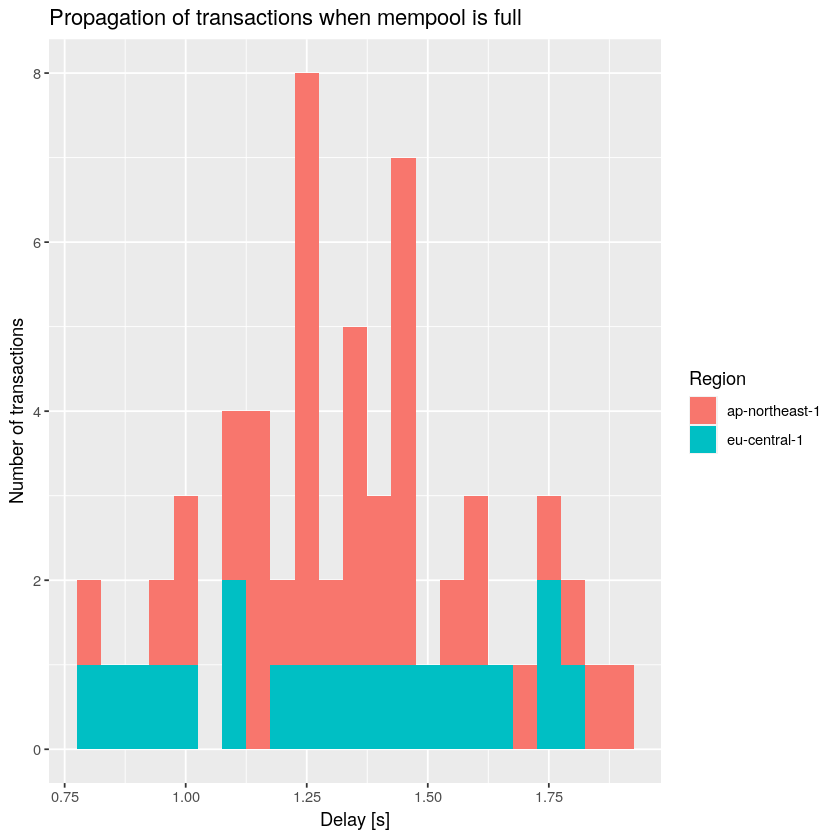

In [42]:
ggplot(
    congestions[
        mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
        on="Tx hash", 
        nomatch=0
    ][!is.na(`Tx logged`), .(`Delay [s]`=as.numeric(`Tx logged` - `Submission time`)), .(`Region`, `Tx hash`)],
    aes(x=`Delay [s]`, fill=`Region`)
) +
    geom_histogram(binwidth=0.05) +
    ylab("Number of transactions") +
    ggtitle("Propagation of transactions when mempool is full")

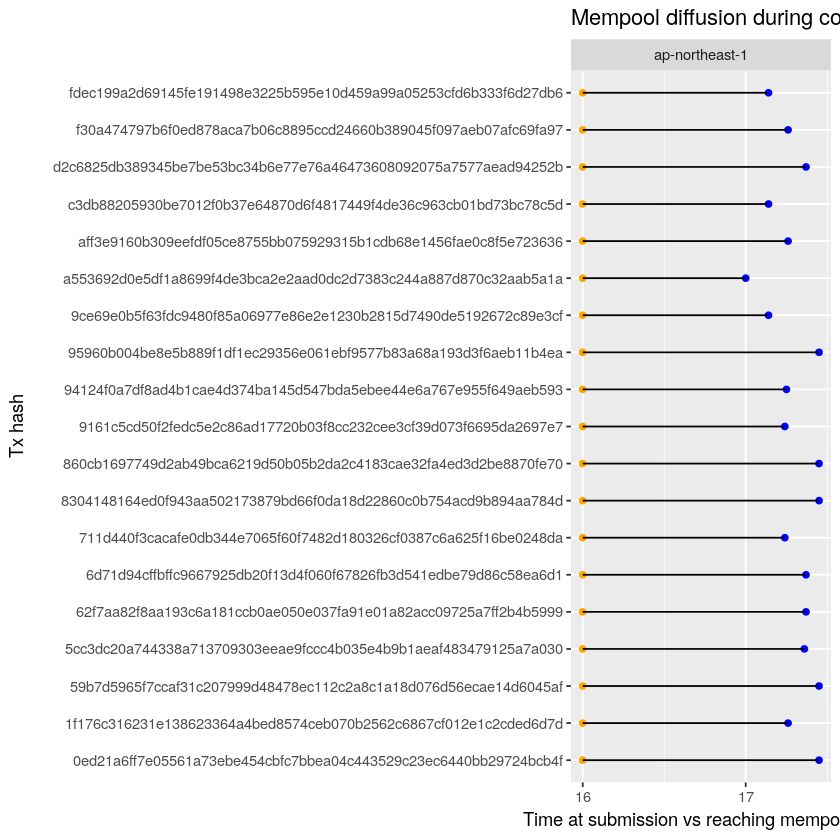

In [43]:
ggplot(
    congestions[
        mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
        on="Tx hash", 
        nomatch=0
    ][
        !is.na(`Tx logged`) & as.character(`Submission time`) < '2025-11-26 14:12:00', 
        .(`Region`, `Tx hash`, `Submission time`, `Tx logged`)
    ],
    aes(x=`Submission time`, y=`Tx hash`)
) +
    geom_point(color="orange") +
    geom_point(aes(x=`Tx logged`, y=`Tx hash`), color="blue") +
    geom_segment(aes(xend=`Tx logged`, yend=`Tx hash`), color="black") +
    facet_grid(. ~ `Region`, scales="free") +
    xlab("Time at submission vs reaching mempool [s]") +
    ggtitle("Mempool diffusion during congestion")

The previous plots shows that only one node ever received the transactions.

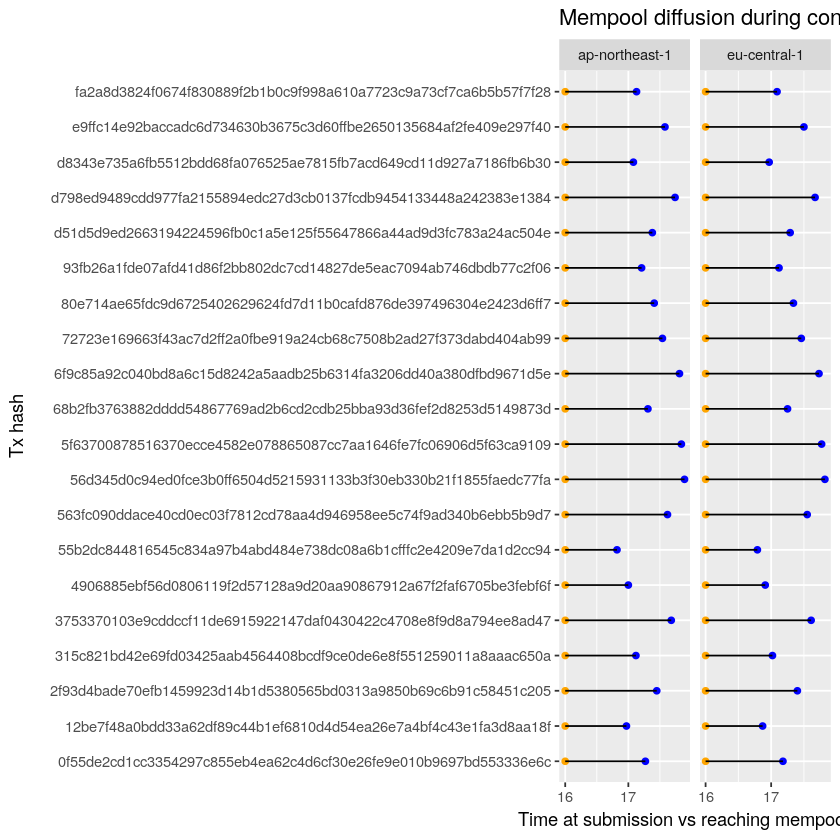

In [44]:
ggplot(
    congestions[
        mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
        on="Tx hash", 
        nomatch=0
    ][
        !is.na(`Tx logged`) & as.character(`Submission time`) > '2025-11-26 14:12:00', 
        .(`Region`, `Tx hash`, `Submission time`, `Tx logged`)
    ],
    aes(x=`Submission time`, y=`Tx hash`)
) +
    geom_point(color="orange") +
    geom_point(aes(x=`Tx logged`, y=`Tx hash`), color="blue") +
    geom_segment(aes(xend=`Tx logged`, yend=`Tx hash`), color="black") +
    facet_grid(. ~ `Region`, scales="free") +
    xlab("Time at submission vs reaching mempool [s]") +
    ggtitle("Mempool diffusion during congestion")

In [45]:
ggsave("congestion.png", units="in", dpi=150, width=8, height=6)

In [46]:
ggsave("congestion.svg", units="in", dpi=150, width=8, height=6)

The previous plot shows that only two nodes ever received the transactions.